In [4]:
import pandas as pd
import numpy as np
import git
from datetime import datetime as dt
from connect_to_mysql import Database
pd.set_option("display.max_columns", None)

In [13]:
repo = git.Repo(".", search_parent_directories=True).git.rev_parse("--show-toplevel")
df = pd.read_csv(f"{repo}/data/cleaning/test_1651834681.csv")
df = df[(df["state"] == "completed")]

In [3]:
df = Database.query_dataframe('rides', "Select * From rides where state = 'completed'")

OperationalError: (2003, "Can't connect to MySQL server on '134.155.95.141:3306' (60)")

In [14]:
df.columns

Index(['id', 'user_id', 'distance', 'number_of_passenger', 'price_operations',
       'price_offer', 'price_payed', 'free_ride', 'payment_type',
       'pickup_address', 'dropoff_address', 'state', 'created_from_offer',
       'created_at', 'scheduled_to', 'dispatched_at', 'pickup_arrival_time',
       'arriving_push', 'vehicle_arrived_at', 'earliest_pickup_expectation',
       'pickup_first_eta', 'pickup_eta', 'pickup_at', 'dropoff_first_eta',
       'dropoff_eta', 'dropoff_at', 'updated_at', 'arrival_deviation',
       'waiting_time', 'boarding_time', 'ride_time', 'trip_time',
       'shortest_ridetime', 'delay', 'longer_route_factor',
       'arrival_indicator', 'rating', 'rating_puenktlichkeit',
       'rating_sauberkeit', 'rating_fahrer', 'rating_find_modstop',
       'rating_other_comments', 'cancellation_reason', 'cancellation_comment',
       'file_name', 'bahn_card_number', 'year_card_type', 'year_card_number',
       'canceled_at', 'rating_question_one', 'rating_question_two'

In [19]:
pd.to_datetime(df["scheduled_to"])[0].month

7

In [43]:
frequencies = pd.DataFrame(df[(pd.to_datetime(df["scheduled_to"]).dt.month == 2) & (pd.to_datetime(df["scheduled_to"]).dt.year == 2022) ].groupby(["pickup_address", "dropoff_address"], group_keys=False).size().to_frame('number_of_drives')).reset_index()

frequencies

,pickup_address,dropoff_address,number_of_drives
0,10002,1005,1
1,10003,3017,3
2,10003,3019,1
3,10003,4037,1
4,10003,6004,18
...,...,...,...
593,9019,1007,1
594,9019,15009,1
595,9021,4007,1
596,9021,4025,1


In [51]:
df_edges = pd.read_excel(
        f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="Liste 2022"
)

In [52]:
df_edges.columns

Index([                      'Start #',                    'Start Name',
                              'Ende #',                     'Ende Name',
                           'Route [m]',                 'Luftlinie [m]',
           'VRN-eTarif\nohne Bahncard',      'VRN-eTarif\nmit BahnCard',
                   'Qualitätszuschlag', 'MoD-Fahrpreis \nohne BahnCard',
        'MoD-Fahrpreis\n mit Bahncard',             0.12680550240634963,
                   0.07159177456207169,             0.18042226487523982,
                    0.5159630940478845,              0.2894135567402895,
                      0.72936660268714,                     'price_mod',
                     'price_mod_2pers',               'price_mod_3pers',
                     'price_mod_4pers',                'price_bahncard',
                'price_bahncard_2pers',          'price_bahncard_3pers',
                'price_bahncard_4pers',           'price_vrn_surcharge',
           'price_vrn_surcharge_2pers',     'price_

In [53]:
df_edges = df_edges[["Start #", "Ende #"]]

In [62]:
df_edges["Start #"] = df_edges["Start #"].astype(str)
df_edges["Ende #"] = df_edges["Ende #"].astype(str)

In [114]:
edges = pd.merge(df_edges, frequencies,  how='left', left_on=['Start #','Ende #'], right_on = ['pickup_address','dropoff_address'])[["Start #", "Ende #", "number_of_drives"]]
edges = edges[edges["number_of_drives"].isna() == False]
edges["number_of_drives"] = 28  / edges["number_of_drives"] 

In [115]:
edges

,Start #,Ende #,number_of_drives
3,1001,1005,14.000000
161,1001,12011,28.000000
206,1002,1008,3.111111
210,1002,1012,28.000000
396,1002,16009,4.666667
...,...,...,...
39869,17007,4020,28.000000
39886,17007,4037,28.000000
39946,17007,11012,28.000000
40114,18005,9005,28.000000


In [80]:
edges["number_of_drives"].fillna(0, inplace=True)

In [106]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(
    edges,
    source = "Start #",
    target = "Ende #",
    edge_attr= "number_of_drives"
)

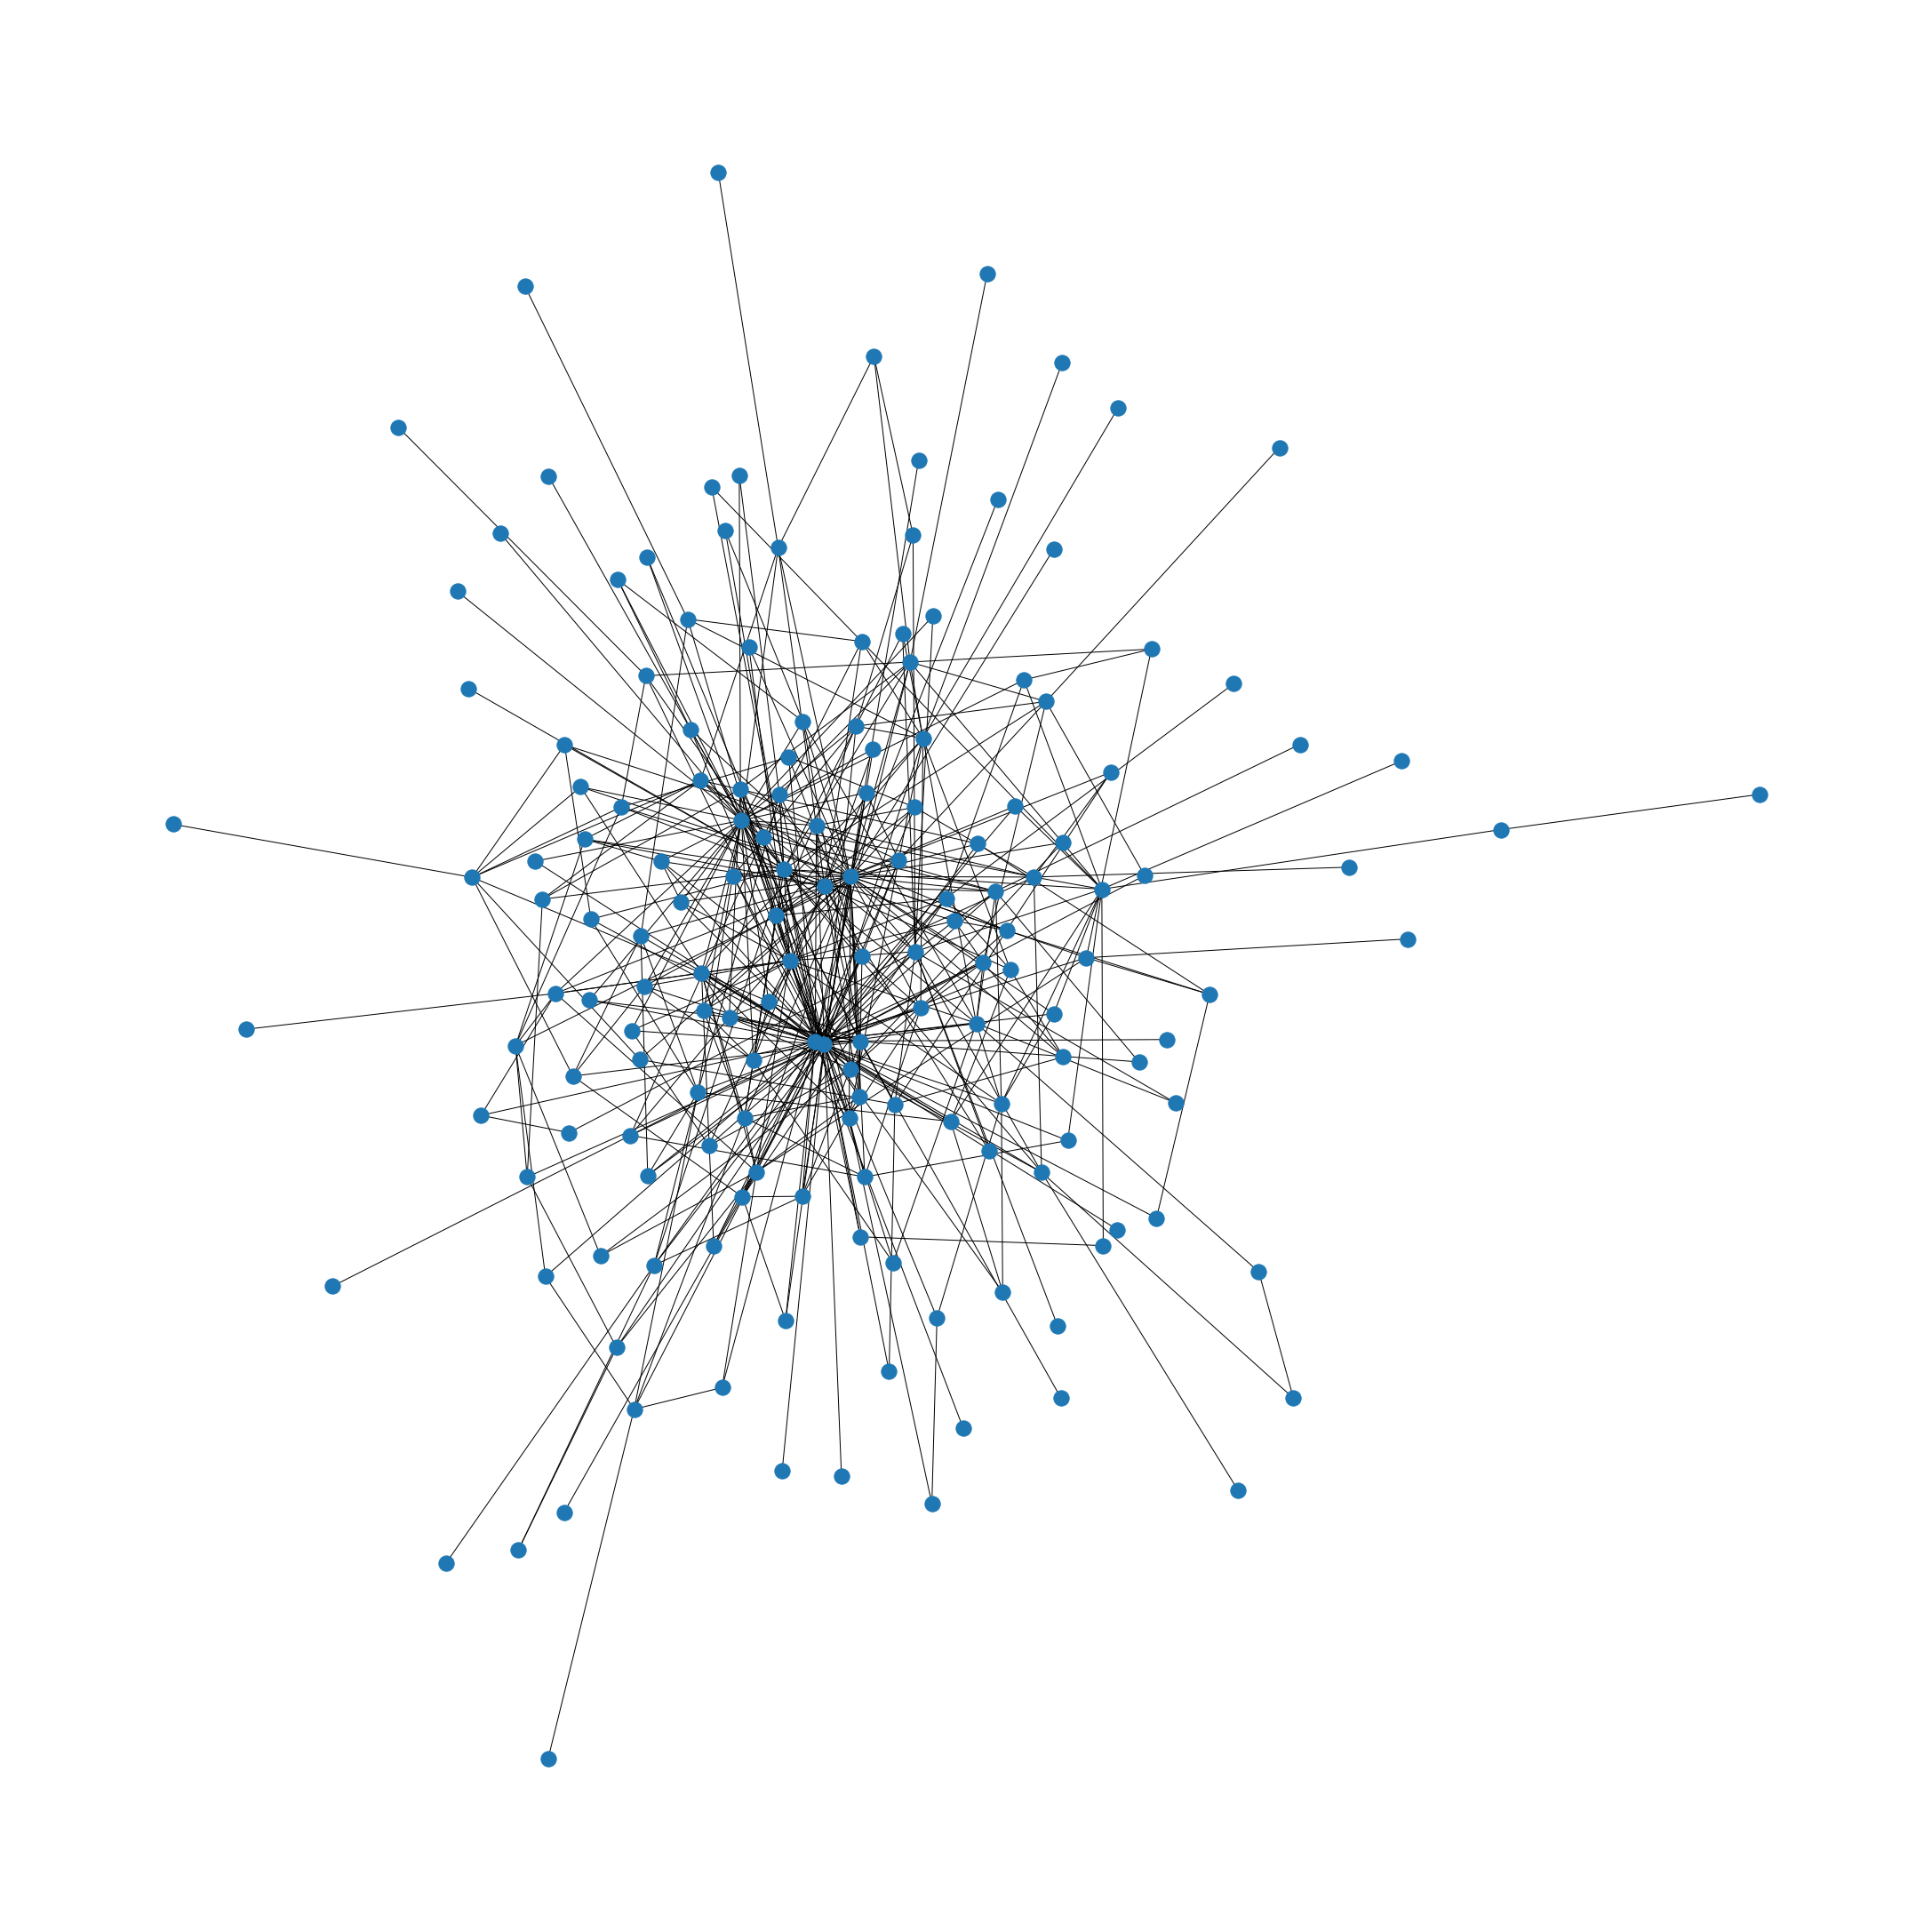

In [110]:
plt.figure(3,figsize=(30,30)) 
nx.draw(G)
plt.show()

In [108]:
print(nx.shortest_path(G, source="10002", target="4007", weight = "number_of_drives"))
print(nx.shortest_path_length(G, source="10002", target="4007", weight="number_of_drives", method='dijkstra'))

['10002', '1005', '4033', '1008', '4007']
77.0
